In [ ]:
import folium
from folium.plugins import HeatMap
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import re, string
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer



# Predicting if an Animal will be re-homed in <30 Days Using Government Data.

Below is a mini-project I started that attempts to predict if an animal taken in from Austin animal shelter will be re-homed in 30 days. I did this to better understand Tree + Ensemble methods in Sklearn.

- This project was inspired by a [mini-course on decision trees from AWS](https://github.com/aws-samples/aws-machine-learning-university-dte). 
- Raw data is taken from [The City of Austin Texas's government data page](https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm).

This project is ongoing, please excuse any grammatical mistakes or unfinished parts!

### Ongoing goals to add (As of 4/13/22):
1. Pull data via SODA API or create local SQL server to perform pulls. Problematic as SODA API won't let me pull "max rows."
2. Attempt other ensemble methods. Ideally ADA boosted trees and NN (when I master this).
3. Finish with fine tuning and assessing over test set.
4. Create final table of results + takeaways.
5. Expand on EDA, clean up as part of presentation to Austin Shelter team.

In [ ]:
#Create Datasets
intake_df = pd.read_csv('Austin_Animal_Center_Intakes.csv')
outcome_df = pd.read_csv('Austin_Animal_Center_Outcomes.csv')
geocoded_df = pd.read_csv('geocoded_locations.csv')

## Data Intake + Prep

Cleaning is one of the most important aspects of any project. Below I attempt to:

1. Simplify variable names, this can lower any confusion to the reader and for long term analysis.
2. Find missing or bad data, these rows could skew our analysis, especially if features contain many missing values or behave in unexpected ways.
3. Merged datasets to have a beginning endline dataset to run EDA over.

-------------------------------------------------

### 1. Simplify columns names

In [ ]:

#Let's simplify all the column names to lower case
def lower_case_col(dataset):
    for i in dataset.columns:
        new_name = i.replace(" ", "_").lower()
        dataset.rename(columns = {i:new_name}, inplace=True)

lower_case_col(intake_df)
lower_case_col(outcome_df)

### 2. Find bad/missing data:

Here I am looking for any columns that might be problematic to our analysis (many missing values, extreme values, or nonsensical values that require more digging).

In [ ]:
#Let's make a function to output what's missing
def percent_missing(df):
    percent_nan = 100* df.isnull().sum() / len(df)
    percent_nan = percent_nan[percent_nan>0].sort_values()
    return percent_nan

In [ ]:
#Only one row contains a missing sex, lets drop this.
percent_missing(intake_df) 


In [ ]:
#Drop one row that contains missing sex
intake_df_clean = intake_df.dropna(subset=['sex_upon_intake']).copy()

#Replace missing names with "Missing"
intake_df_clean['name'] = intake_df_clean['name'].fillna("Missing")

In [ ]:
#Outcome data has a few observations with missing values, especially in some important metrics. However, its only outcome_type that matters for this analysis (this tells us wether an animal was adopted, transferred, euthanized, etc..). 
#Outcome_subtype is useful for EDA and further analysis but not so much for prediction so we can ignore for now.
percent_missing(outcome_df) 

In [ ]:
#Drop rows that missing outcome
outcome_df_clean =  outcome_df.dropna(subset=['outcome_type']).copy()

#Replace missing names with "Missing"
outcome_df_clean['name'] = intake_df_clean['name'].fillna("Missing")

### 3. Merge Intake & Outcome Data:

Now merge the semi-cleaned data together so I can continue with feature engineering and EDA. To do this I first create merging variables.

The same animal can show up multiple times, however their intake and subsequent outcome are always in order. For instance if dog A has been intaken 5 times in our data, then they'll be in the outcome 5 times, if not the animal is still waiting for an outcome. I can't merge these multiple instances on ID and date as an animal will come in a different date it leaves, but I can sort on date in both dataframes and create a unique merge variable instead.

In [ ]:
#Let's make an "month taken in" variable, it might be the case adoptions happen more often during holidays?
def d_m_y(var,name):
    date = pd.to_datetime(var.loc[:,'datetime'])
    var[name + '_month'] = date.dt.month
    var[name + '_datetime'] = date
    var = var.drop(['datetime'], axis=1)
    
d_m_y(intake_df_clean, 'intake')
d_m_y(outcome_df_clean, 'outcome')



In [ ]:
def sort_for_merge(var, name):
    var['merge_counter'] = var.sort_values(by=[name + '_datetime']).groupby(['animal_id']).cumcount()+1
    
sort_for_merge(intake_df_clean, 'intake')
sort_for_merge(outcome_df_clean, 'outcome')

#Now merge
merged_df = intake_df_clean.merge(outcome_df_clean[['outcome_datetime',
                                                        'outcome_month',
                                                        'outcome_type',
                                                        'animal_id',
                                                        'merge_counter']],
                                  on = ['animal_id',
                                        'merge_counter'],
                                    how='inner')

## EDA + Feature Engineering

This step attempts to combine multiple aspects of any data science project together:
1. Identify worthwhile features to use and determine what features to create.
2. Create new features. Many of the raw features given are not ready to run EDA over. I need to still fix and create features.
3. Perform EDA and identify any issues or interesting relationships.
4. Drop observations or clean features of interest.
5. Specify features types and transform as needed

Feature Engineering is an ongoing process however, so what is listed above is only a portion of what I do on this project. Moreover, this process is an overarching step of this project. Under the hood and behind the curtains lies hundreds of lines of depreciated code, useless features, and other analysis not included. Later on I will continue feature engineering by dummying our variables (after EDA).

------------------------------------

### 1.Identify
First I need to think of what features in the intake data could potentially predict if an animal will be rehomed, I don't want to throw the whole kitchen sink of features in potentially adding noise to my analysis. Second, I need to understand and define "rehomed." What is the key performance metric I should use?

Much of this "Identify" comes during EDA or via simple inspection of my data. I already know by looking that intake Age is important, breed, and time of adoption.

### 2. Create

After Identifying what I could use in the intake data, I need to create additional features and retool existing ones to my liking. Some potential ideas I saw:
1. Seasonality might matter, having an animal come in near Christmas might spur higher adoptions.
2. Age needs to be standard across animals, lets turn it into months.
3. How should we deal with purebred and mixed animals?

In [ ]:
#Lets make age in terms of months 
def age_to_num(var):
    num, date = var.split(' ')
    num = int(num)
    if 'year' in date :
        num = num*12
    elif 'week' in date:
        num = num/4
    elif 'day' in date:
        num = num/30
    else:
        num   
    if num < 0:
        num = np.nan    
    return(num)   

merged_df['age'] = merged_df['age_upon_intake'].apply(age_to_num)

In [ ]:
#Let's make a "purebred" variable for dogs. This should only really matter for dogs, as for cats "shorthair mix" & "shorthair" for a cat are identical. Moreover, what is the difference between a "cow" and "cow mix?"
merged_df.loc[(merged_df.animal_type == "Dog") & ~(merged_df.breed.str.contains("Mix|/")), "purebred"] = 1
merged_df['purebred']=merged_df['purebred'].fillna(0)

In [ ]:
#Create our Y outcomes:
merged_df['days'] = (merged_df['outcome_datetime'] - merged_df['intake_datetime']) / np.timedelta64(1,'D')
merged_df['rehomed_in_30_days'] = np.where( (merged_df['days'] <= 30) & (merged_df['outcome_type'].str.contains('Adopt|Rto|Return to Owner')), 1, 0)
merged_df['rehomed'] = np.where(merged_df['outcome_type'].str.contains('Adopt|Rto|Return to Owner'), 1, 0)
merged_df['adopted'] = np.where(merged_df['outcome_type'].str.contains('Adopt'), 1, 0)

## EDA

In [ ]:
#Maps
def generateBaseMap(default_location=[30, -97.733330], default_zoom_start=10):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map
basemap = generateBaseMap()

folium.TileLayer('cartodbpositron').add_to(basemap)
folium.Marker(location=[30.2527847, -97.6926073],
              popup='Austin Animal Shelter', 
              icon = folium.Icon(color='green',icon='info-sign')).add_to(basemap)
HeatMap(data=geocoded_df[['latitude','longitude']].groupby(['latitude','longitude']).sum().reset_index().values.tolist(), radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap


First lets plot animal age by type. As we can see there's a concerning amount of outliers by animal type in our data (that is observations 1.5*IQR + 3Q). This is something we ought to drop later on.

In [ ]:
#animal ages
ax = sns.boxplot(x="animal_type", y="age", showfliers=True,data=merged_df)
ax.set_ylabel("Age (Months)")
ax.set_xlabel("Animal Type")
ax.set_title("Average Ages of Animals (All)")

It seems like there's a fair amount of outliers by animal type, lets fix this now before I move on with EDA.

In [ ]:
def iqr_drop(df):
    q1 = df.age.quantile(0.25)
    q3 = df.age.quantile(0.75)
    iqr = q3 - q1 
    df = df.iloc[np.where((q1 - 1.5*iqr < df.age) & (df.age < q3 + 1.5*iqr))[0], :] 
    return df

df = merged_df
for i in merged_df.animal_type.unique():
    q1 = df[df.animal_type == i].age.quantile(0.25)
    q3 = df[df.animal_type == i].age.quantile(0.75)
    iqr = q3 - q1 
    drop_q1 = q1 - 1.5*iqr
    drop_q3 = q3 + 1.5*iqr
    df = df.drop(df[(df.animal_type == i) &
                                         (df.age < drop_q1)].index)
    df = df.drop(df[(df.animal_type == i) &
                                        (df.age > drop_q3)].index)

merged_df_clean = df
    
        

ax = sns.boxplot(x="animal_type", y="age", showfliers=True,data=merged_df_clean)
ax.set_title("Ages without Outliers")


In [ ]:
ax = sns.violinplot(x='animal_type',y="age",data=merged_df_clean, hue='rehomed_in_30_days', split='True', palette='rainbow')
ax.set_ylabel("Age (Months)")
ax.set_xlabel("Animal Type")
ax.set_title("Adoption, Age, and Animal Type")
ax.legend(title="Rehomed in 30 Days",
          loc='best', fontsize='small')



In [ ]:
table_df = pd.DataFrame()
table_df['Rehomed'] = merged_df_clean['rehomed']
table_df['Rehomed Within 30 Days'] = merged_df_clean['rehomed_in_30_days']
table_df['Animal Type'] = merged_df_clean['animal_type']
table_df['Intake Type'] = merged_df_clean['intake_type']

pivot = np.round(pd.pivot_table(table_df, index=['Animal Type'],
               values=['Rehomed','Rehomed Within 30 Days'],
               aggfunc=[np.mean, np.sum],
               margins=True,
               margins_name='Total'),2)

pivot

In [ ]:
pivot = np.round(pd.pivot_table(table_df, index=['Intake Type'],
               values=['Rehomed','Rehomed Within 30 Days'],
               aggfunc=[np.mean, np.sum],
               margins=True,
               margins_name='Total'),2)

pivot

In [ ]:
sns.set(style="darkgrid")
ax = sns.catplot(
    x = 'animal_type',
    y= 'rehomed_in_30_days',
    col = 'intake_type',
    data = merged_df_clean,
    kind = 'bar',
    ci = None
)
ax.set_ylabels('Adopted Within 30 Days')
ax.set_xlabels('')

In [ ]:
sns.countplot(x='animal_type', data=merged_df_clean)

In [ ]:
sns.kdeplot(x='outcome_month', 
            data=merged_df_clean,
            fill=True)

In [ ]:
mode = lambda x: x.mode() if len(x) > 2 else np.array(x)
merged_df_clean.groupby('animal_type')['breed'].agg(mode)

In [ ]:
merged_df_clean.groupby('animal_type')['breed'].nunique()

### Dealing with Strings

I have a strong interest in using the animal's name, found location, intake type, condition, breed, and color in our analysis. First I need to actually clean the text before I can vectorize them. 

As a note: This portion was heavily inspired by the AWS course where they introduced me to text cleaning and vectorization tools.

What I have in mind is this:
1. Use SnowballStemmer to simplify longer strings like colors, address, or name
2. Get rid of useless characters such as "/" "*" "()" "." in strings
3. Remove any white space

In [ ]:
#First SnowballStemmer

#specify stop_words: words that can be ignored when simplifying our strings
stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

stemmer = SnowballStemmer('english')

def preProcessText(text):
    # lowercase and strip leading/trailing white space
    text = text.lower().strip()
    
    # remove HTML tags
    text = re.compile('<.*?>').sub('', text)
    
    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    # remove extra white space
    text = re.sub('\s+', ' ', text)
    
    return text

def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)
    
    return text


def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)

# Clean the text features
for c in ['name', 'breed', 'color', 'found_location', 'intake_condition']:
    print('Text cleaning: ', c)
    merged_df_clean[c] = [cleanSentence(item, stop_words, stemmer) for item in merged_df_clean[c].values]
    merged_df[c] = [cleanSentence(item, stop_words, stemmer) for item in merged_df[c].values]

## Feature Selection & Train Test Split

### Selecting Features + Outcome:
After EDA and some manual observation I believe I found a set of interesting features to use to predict adoption and rehoming. To simplfy this process down the road I will specify three type of features that I will use (and subsequently clean).

1. Numerical: Any feature that is continuos or ordinal, i.e. the feature is coded in such a way that high or lower values correspond to some implicit ordering or intensity. Think age, income, weight, size, etc..
2. Categorical: Any feature that can be broken in discrete values, however unlike ordinal, higher or lower values do not correspond to any ordering or intensity. Think color, breed, etc..
3. String: Any feature whose information is encoded as a string, where no well defined structure is present. Think name, address, review, etc..

In [ ]:
merged_df_clean.columns

In [ ]:
num_feats = ['age']
cat_feats = ['animal_type', 'intake_month', 'sex_upon_intake', 'intake_condition', 'purebred']
#Include color + breed in strings as these features contain multiple values that can be seemingly mixed up. I don't want to treat a pit-bull/lab mix any differently as a lab/put-bull mix.
str_feats = ['name', 'color', 'breed', 'found_location']

In [ ]:
#Lets specify our Y for now:
x = num_feats + cat_feats + str_feats
y = 'rehomed_in_30_days'

In [ ]:
train_data, test_data = train_test_split(merged_df, test_size=0.2, shuffle=True, random_state=1)

#From the test data further split into validation (we use throughout process) & test (use only at end)
val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=True, random_state=1)


Let's ensure the training and test data have an equal size amount of outcomes to train over.

In [ ]:
outcome_0_train = train_data[train_data[y] == 0]
outcome_1_train = train_data[train_data[y] == 1]

print(f'Class 0 in Training proportion is: {len(outcome_0_train)}')
print(f'Class 1 in Training proportion is: {len(outcome_1_train)}')

outcome_0_test = test_data[test_data[y] == 0]
outcome_1_test = test_data[test_data[y] == 1]

print(f'Class 0 in Testing proportion is:{len(outcome_0_test)}')
print(f'Class 1 in Testing proportion is:{len(outcome_1_test)}')


In [ ]:
upsampled_class_1_no = outcome_1_train.sample(n=len(outcome_0_train), replace=True, random_state=1)
train_data = pd.concat([outcome_0_train, upsampled_class_1_no])
train_data = train_data.sample(frac=1).reset_index(drop=True)

outcome_0_train = train_data[train_data[y] == 0]
outcome_1_train = train_data[train_data[y] == 1]

print(f'Class 0 in Training proportion is: {len(outcome_0_train)}')
print(f'Class 1 in Training proportion is: {len(outcome_1_train)}')


## Process Data + Build Pipline

Below we will process our data (transform categorical into dummies and vectorize text data), then create a pipeline that can take in any new data and work it into our models seamlessly. 

For numerical values we'll: 
1. Impute any missing values with the mean (we saw very early on not many age's were missing, so a simple imputation will work well)
2. Standardize values (for non-tree models)

For categorical we'll:
1. Impute any missing with a unique categorical value (missing column = 1)
2. Transform into dummies with onehotencoder.

For Strings we'll:
1. Vectorize (just like creating dummies that equal 1 if the word exist in the row)


In [57]:
num_pipe_tree = Pipeline([
    ('num_tree_imputer', SimpleImputer(strategy='mean'))
    ])

num_pipe = Pipeline([
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('standardize', StandardScaler())
                     ])

cat_pipe = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', 
                                  fill_value='missing')),
    ('coder',OneHotEncoder(handle_unknown='ignore'))
                     ])


text_pipe_name = Pipeline([
    ('text_vect_name', CountVectorizer(binary=True, max_features=50))
    ])
text_pipe_location = Pipeline([
    ('text_vect_name', CountVectorizer(binary=True, max_features=150))
    ])
text_pipe_breed = Pipeline([
    ('text_vect_name', CountVectorizer(binary=True))
    ])
text_pipe_color = Pipeline([
    ('text_vect_name', CountVectorizer(binary=True,max_features=50) )
    ])


#Put all into a single transformer
tree_transformer = ColumnTransformer([
    ('numerical_transform', num_pipe_tree, num_feats),
    ('categorical_transform', cat_pipe, cat_feats),
    ('text_transform_name', text_pipe_name, str_feats[0]),
    ('text_transform_color', text_pipe_color, str_feats[1]),
    ('text_transform_breed', text_pipe_breed, str_feats[2]),
    ('text_transform_loc', text_pipe_location, str_feats[3])
    
])

logit_transformer = ColumnTransformer([
    ('numerical_transform', num_pipe, num_feats),
    ('categorical_transform', cat_pipe, cat_feats),
    ('text_transform_name', text_pipe_name, str_feats[0]),
    ('text_transform_color', text_pipe_color, str_feats[1]),
    ('text_transform_breed', text_pipe_breed, str_feats[2]),
    ('text_transform_loc', text_pipe_location, str_feats[3])
])



### Specify Models to Run

In [58]:
# Get train data to train the network
X_train = train_data[x]
y_train = train_data[y]

# Get validation data to validate the network 
X_val = val_data[x]
y_val = val_data[y]

# Get test data to test the network
X_test = test_data[x]
y_test = test_data[y]

print('Datasets shapes before processing: ', X_train.shape, X_val.shape, X_test.shape)

a = tree_transformer.fit_transform(X_train)
b = tree_transformer.transform(X_val)
c = tree_transformer.transform(X_test)

print('Datasets shapes after processing: ', a.shape, b.shape, c.shape)

Datasets shapes before processing:  (113004, 10) (13632, 10) (13633, 10)
Datasets shapes after processing:  (113004, 665) (13632, 665) (13633, 665)


In [67]:
#Classic Tree
classic_tree = DecisionTreeClassifier(random_state=1)
classic = Pipeline([
    ("preprocessor", tree_transformer), 
     ("classic_tree", classic_tree)
])

#Random Tree
rfc_tree = RandomForestClassifier(random_state=1)
rfc = Pipeline([
    ("preprocessor", tree_transformer), 
     ("rfc_tree", rfc_tree)
])

#log
log = Pipeline([
    ("preprocessor", logit_transformer), 
     ("log", LogisticRegression(max_iter=1000000000000))
])

#regularized log
log_l2_pipe = Pipeline([
    ("preprocessor", logit_transformer), 
     ("log", LogisticRegression(penalty='l2',
                            solver='saga',
                            C=.01,
                            max_iter=1000))])


In [68]:
from sklearn import set_config
set_config(display='diagram')
rfc


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_transform',
                                                  Pipeline(steps=[('num_tree_imputer',
                                                                   SimpleImputer())]),
                                                  ['age']),
                                                 ('categorical_transform',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('coder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['animal_type',
                                                   'intake_month',
                                                   'sex_...
                                                  Pipeline(steps=[('text_vect_name',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'color'),
                                                 ('text_transform_breed',
                                                  Pipeline(steps=[('text_vect_name',
                                                                   CountVectorizer(binary=True))]),
                                                  'breed'),
                                                 ('text_transform_loc',
                                                  Pipeline(steps=[('text_vect_name',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'found_location')])),
                ('rfc_tree', RandomForestClassifier(random_state=1))])

## Fit & Run Naive Models

In [69]:
rfc.fit(X_train, y_train)
classic.fit(X_train, y_train)
log.fit(X_train, y_train)
log_l2_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_transform',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['age']),
                                                 ('categorical_transform',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('coder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['anima...
                                                  Pipeline(steps=[('text_vect_name',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=50))]),
                                                  'color'),
                                                 ('text_transform_breed',
                                                  Pipeline(steps=[('text_vect_name',
                                                                   CountVectorizer(binary=True))]),
                                                  'breed'),
                                                 ('text_transform_loc',
                                                  Pipeline(steps=[('text_vect_name',
                                                                   CountVectorizer(binary=True,
                                                                                   max_features=150))]),
                                                  'found_location')])),
                ('log',
                 LogisticRegression(C=0.01, max_iter=1000, solver='saga'))])

In [71]:
train_predictions_rfc = rfc.predict(X_val)
print("RFC TREE:",classification_report(y_val, train_predictions_rfc))
train_predictions_class = classic.predict(X_val)
print("DECISION TREE:",classification_report(y_val, train_predictions_class))
train_predictions_log = log.predict(X_val)
print("LOG:",classification_report(y_val, train_predictions_log))
train_predictions_log_l2 = log_l2_pipe.predict(X_val)
print("LOG L2:",classification_report(y_val, train_predictions_log_l2))


RFC TREE:               precision    recall  f1-score   support

           0       0.73      0.74      0.74      6950
           1       0.73      0.72      0.72      6682

    accuracy                           0.73     13632
   macro avg       0.73      0.73      0.73     13632
weighted avg       0.73      0.73      0.73     13632

DECISION TREE:               precision    recall  f1-score   support

           0       0.66      0.75      0.70      6950
           1       0.70      0.61      0.65      6682

    accuracy                           0.68     13632
   macro avg       0.68      0.68      0.68     13632
weighted avg       0.68      0.68      0.68     13632

LOG:               precision    recall  f1-score   support

           0       0.73      0.66      0.69      6950
           1       0.68      0.75      0.71      6682

    accuracy                           0.70     13632
   macro avg       0.71      0.70      0.70     13632
weighted avg       0.71      0.70      0.70 

In [106]:
a = list(rfc['preprocessor'].transformers_[1][1]['coder'].get_feature_names(cat_feats))
b = list(sorted(rfc['preprocessor'].transformers_[2][1]['text_vect_name'].vocabulary_.keys()))
c = list(sorted(rfc['preprocessor'].transformers_[3][1]['text_vect_name'].vocabulary_.keys()))
d = list(sorted(rfc['preprocessor'].transformers_[4][1]['text_vect_name'].vocabulary_.keys()))
e = list(sorted(rfc['preprocessor'].transformers_[5][1]['text_vect_name'].vocabulary_.keys()))

cols = ['age'] + a + b + c + d + e 

coef_tree = pd.DataFrame({'features': cols, 'values': rfc_tree.feature_importances_}).sort_values(by='values',ascending=False)


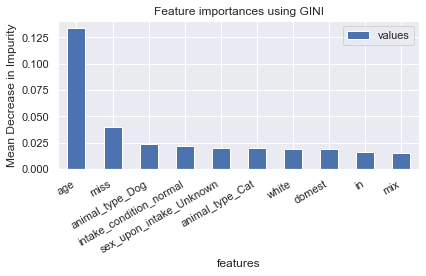

In [130]:
fig, ax = plt.subplots()
coef_tree.head(10).plot.bar(x='features',ax=ax)
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_title("Feature importances using GINI")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()

### Fine-tuning Hyperparameter

In [ ]:
#gridsearch cv on decision tree
### PIPELINE GRID_SEARCH ###
############################

# Parameter grid for GridSearch
param_grid={'classic_tree__max_depth': [100, 200, 300],#, 50, 75, 100, 125, 150, 200, 250], 
            'classic_tree__min_samples_leaf': [5, 10, 15],#, 25, 30],
            'classic_tree__min_samples_split': [2, 5, 15]#, 25, 30, 45, 50]
           }

grid_search = GridSearchCV(classic, # Base model
                           param_grid, # Parameters to try
                           cv = 5, # Apply 5-fold cross validation
                           verbose = 1, # Print summary
                           n_jobs = -1 # Use all available processors
                          )

# Fit the GridSearch to our training data
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)
# Get the best model out of GridSearchCV
classifier = grid_search.best_estimator_

# Fit the best model to the train data once more
classifier.fit(X_train, y_train)

In [ ]:

# Use the fitted model to make predictions on the train dataset
val_predictions = classifier.predict(X_val)

print('Model performance on the train set:')
print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))
print("val accuracy:", accuracy_score(y_val, val_predictions))    

In [ ]:
#gridsearch cv on decision tree
### PIPELINE GRID_SEARCH ###
############################

# Parameter grid for GridSearch
param_grid={'rfc_tree__n_estimators': [300],#, 50, 75, 100, 125, 150, 200, 250], 
            'rfc_tree__max_features': ['auto'],#, 25, 30],
            'rfc_tree__max_depth': [100, 200, 300],#, 50, 75, 100, 125, 150, 200, 250], 
            'rfc_tree__min_samples_leaf': [5, 10, 15],#, 25, 30],
            'rfc_tree__min_samples_split': [2, 5, 15]#, 25, 30, 45, 50]
           }





grid_search = GridSearchCV(rfc, # Base model
                           param_grid, # Parameters to try
                           cv = 5, # Apply 5-fold cross validation
                           verbose = 1, # Print summary
                           n_jobs = -1 # Use all available processors
                          )

# Fit the GridSearch to our training data
grid_search.fit(X_train, y_train)

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)
# Get the best model out of GridSearchCV
classifier = grid_search.best_estimator_

# Fit the best model to the train data once more
classifier.fit(X_train, y_train)


# Use the fitted model to make predictions on the train dataset
val_predictions = classifier.predict(X_val)

print('Model performance on the train set:')
print(confusion_matrix(y_val, val_predictions))
print(classification_report(y_val, val_predictions))
print("val accuracy:", accuracy_score(y_val, val_predictions)) 

In [ ]:
coef_logit = pd.DataFrame(zip(X_train.columns, np.transpose(log.coef_.tolist()[0])), columns=['features', 'coef'])
coef_logit = coef_logit.sort_values(by='coef', ascending=False).reset_index()
coef_logit

In [ ]:
coef_tree = pd.DataFrame(X_train.columns, new_tree.feature_importances_, columns=['features'])
coef_tree.sort_index(ascending=False).head(5)



In [ ]:
coef_logit[coef_logit['features'].str.contains('Pit')]

In [ ]:
coef_ada = pd.DataFrame(zip(X_train.columns, np.transpose(rfc_tree.feature_importances_)), columns=['features', 'coef'])
coef_ada = coef_ada.sort_values(by='coef', ascending=False).reset_index()
coef_ada

In [ ]:

print(classification_report(y_predict, y_test))
plot_confusion_matrix(log,Scaler.transform(X_test), y_test, normalize='true')